In [34]:
from utils import sars2_genome_info, add_syn_mut_attribute, add_mut_accumulation_attr, add_del_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats, DateToStr
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import requests
import json

## Figure 1 Supplement: Doubling number of isolates including in tree does not impact correlation between clade success and S1 substitution accumulation


Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 19694 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15/20k

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15_20k.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add information about synonymous mutations as an attribute of nodes on the tree

In [4]:
tree = add_syn_mut_attribute(tree)

Add an attribute to each node that gives the total number of mutations (synonymous SNPs, or nonsynonymous SNPs plus deletions) accumulated between the tree root and that node (including mutations on the node). 

In [5]:
tree = add_mut_accumulation_attr(tree)

Add an attribute to each node that lists deletions and nonsynonymous SNPs separately

In [6]:
tree = add_del_accumulation_attr(tree)

Make a list of regions of the genome to consider. Each element of the list is a tuple with the format: 
(region/type of mutation, node attribute name, gene length for normalizing mutation count, nonsynonymous or synonymous)

In [7]:
regions_to_consider = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S1_synonymous', 's1_syn_accumulation', 'S1', 'syn'), 
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('E', 'e_accumulation', 'E', 'nonsyn'), ('M', 'm_accumulation', 'M', 'nonsyn'), 
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn'), 
                       ('S2', 's2_accumulation', 'S2', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn')]


Make a tidy dataframe to plot: 
1) accumulation of mutations over time for each region of the genome

2) mutation accumulation versus logistic growth

In [10]:
# initialize list to store relevant information for Fig1A and B
muts_information = []

# only look at internal nodes
for node in tree.find_clades(terminal=False):

    # only nodes within 6 weeks of May 15 have logisitic growth rates
    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        # get inferred node date
        date = node.node_attrs["num_date"]["value"]
        
        # get emerging lineage assignment of node 
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
            emerging_lineage = convert_linege_names(emerging_lineage)

        # make tidy df for seaborn plotting
        for r in regions_to_consider:
            # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
            # add figure_lineage key to group 
            muts_information.append({'clade': node.name, 'date': date,
                                     'emerging_lineage': emerging_lineage,
                                     'mut_location': r[0], 
                                     'num_muts': node.node_attrs[r[1]],  
                                     'muts_per_codon': node.node_attrs[r[1]]/gene_lengths_aa[r[2]],
                                     'num_deletions': node.node_attrs['deletion_accumulation'][r[2]], 
                                     'dels_per_codon': node.node_attrs['deletion_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'snps_per_codon': node.node_attrs['nonsyn_snps_accumulation'][r[2]]/gene_lengths_aa[r[2]],
                                     'logistic_growth': logistic_growth})


# make list into dataframe
muts_information_df = pd.DataFrame(muts_information)

Get p-value for each gene by comparing empirical correlation coefficient to randomizations

In [58]:
def get_randomized_rvalues(gene):

    path = f'randomization_results/2021-05-15_20k/randomizations/{gene}/'
    randomization_files = [path+f for f in listdir(path) if isfile(join(path, f))]
    
    to_plot = pd.DataFrame(columns = ["data","iteration","gene","nonsyn_syn","r_value"])

    for data_file in randomization_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            index = int(data['iteration'])
            df = pd.DataFrame(data, index=[index])
            to_plot = pd.concat([to_plot, df])
            
    r_values = list(to_plot['r_value'])
            
    return r_values

In [29]:
# add column to color lineages as is done in manuscript for the primary analysis
manuscript_lineage_map = {'basal': 'basal',
 'A.23.1': 'other VOI',
 'B.1.351 (Beta)': 'Beta',
 'B.1.526 (Iota)': 'other VOI',
 'B.1.621': 'other VOI',
 'B.1.427/429 (Epsilon)': 'other VOI',
 'B.1.620': 'other VOI',
 'B.1.617.1 (Kappa)': 'other VOI',
 'B.1.617.2 (Delta)': 'Delta',
 'B.1.619': 'other VOI',
 'B.1.525 (Eta)': 'other VOI',
 'B.1.1.7 (Alpha)': 'Alpha',
 'P.1 (Gamma)': 'Gamma',
 'C.36.3': 'other VOI',
 'C.37 (Lambda)': 'other VOI',
 'B.1.1.519': 'other VOI',
 'B.1.1.318': 'other VOI'}

muts_information_df['manuscript_lineage'] = muts_information_df['emerging_lineage'].map(manuscript_lineage_map)

Look at the relationship between mutation accumulation and logistic growth rate in other genes as well. This is Figure 1 Supplement 3

In [110]:
def plot_fig1supp_20K(filename=None):
    
    #only color alpha, beta, delta, gamma, and group other vois
    # the basal lineage will be gray
    cmap = {'Alpha': "#5E1D9D", 'Beta':"#416CCE",'Delta':"#89BB6B",
            'Gamma':"#E14F2A", 'other VOI':"#DDAA3C",'basal': "#ABABAB"}
    

    # whether or not to plot legend, based on subplot index
    plot_legend = {**{0:False}, **{1:True}, **{x:False for x in range(2,8)}}
    
    # initialize figure format
    fig, axes = plt.subplots(4,2, figsize=(9,8), sharey=True, sharex=True)
    plt.tight_layout()
    sns.set_style('white')
    
    # plot s1, s2, rdrp, n, m, orf7a, nsp6, nsp4
    fig1supp_categories = [('S1', 's1_accumulation', 'S1', 'nonsyn'), ('S2', 's2_accumulation', 'S2', 'nonsyn'),  
                       ('RdRp', 'rdrp_accumulation', 'RdRp', 'nonsyn'), ('N', 'n_accumulation', 'N', 'nonsyn'), 
                       ('M', 'm_accumulation', 'M', 'nonsyn'), ('ORF7a', 'orf7a_accumulation', 'ORF7a', 'nonsyn'),
                       ('Nsp6', 'nsp6_accumulation', 'Nsp6', 'nonsyn'), ('Nsp4', 'nsp4_accumulation', 'Nsp4', 'nonsyn')]
    
    for i, ax in enumerate(axes.flat):

        ax = sns.scatterplot(x="logistic_growth", y="muts_per_codon", hue= 'manuscript_lineage',
                      hue_order= list(cmap.keys()), palette=cmap,
                      data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                      ax=ax, legend=plot_legend[i])
        sns.regplot(x="logistic_growth", y="muts_per_codon", scatter=False, ax=ax, 
                    data = muts_information_df[muts_information_df['mut_location']==fig1supp_categories[i][0]], 
                    line_kws={"color":'black'}, ci=95)
        ax.set_title(f'{fig1supp_categories[i][2]}', 
                     fontsize = 16, fontweight='bold')
        
        # run linear regression on the plot
        slope, r_value = get_linear_reg_stats(muts_information_df, fig1supp_categories[i][0], 
                                              "logistic_growth", 'muts_per_codon')

        
        # get p-value
        randomized_r_values = get_randomized_rvalues(fig1supp_categories[i][2])
        
        pvalue= len([element for element in randomized_r_values if element > r_value])/len(randomized_r_values)
        if pvalue < 0.001:
            pvalue = '< 0.001'
        else:
            pvalue = round(pvalue, 2)
        
        ax.annotate(f'$r$: {r_value} \np-value: {pvalue}', xy=(-20,0.033), size=14, va='top', ha='left')

    # Add secondary axis showing absolute number of mutations for panel A subplots
    ax_1 = fig.axes[0].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S1'], 
                                                  lambda x: x / gene_lengths_aa['S1']))
    ax_2 = fig.axes[1].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['S2'], 
                                                  lambda x: x / gene_lengths_aa['S2']))
    ax_3 = fig.axes[2].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['RdRp'], 
                                                  lambda x: x / gene_lengths_aa['RdRp']))
    ax_4 = fig.axes[3].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['N'], 
                                                  lambda x: x / gene_lengths_aa['N']))
    ax_5 = fig.axes[4].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['M'], 
                                                  lambda x: x / gene_lengths_aa['M']))
    ax_6 = fig.axes[5].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['ORF7a'], 
                                                  lambda x: x / gene_lengths_aa['ORF7a']))
    ax_7 = fig.axes[6].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp6'], 
                                                  lambda x: x / gene_lengths_aa['Nsp6']))
    ax_8 = fig.axes[7].secondary_yaxis('right', functions=(lambda x: x * gene_lengths_aa['Nsp4'], 
                                                  lambda x: x / gene_lengths_aa['Nsp4']))
    # make secondary axis gray
    for ax in [ax_1, ax_2, ax_3, ax_4, ax_5, ax_6, ax_7, ax_8]:
        ax.spines['right'].set_color('#888888')
        ax.tick_params(colors='#888888')
    # label outer axes
    for ax in [ax_2, ax_4, ax_6, ax_8]:  
        ax.set_ylabel('Number of mutations', fontsize = 14, color='#ABABAB')
        
    # label x and y axis of the outer subplots
    for i, ax in enumerate(axes.flat):
        if i in [6,7]:
            ax.set_xlabel('Logistic Growth Rate', fontsize = 14)
        if i in [0, 2, 4, 6]:
            ax.set_ylabel('Mutations per codon', fontsize = 14)
        # put emerging lineage legend on the bottom right plot
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(-0.05, 1.8), 
                            fontsize=13, title_fontsize='large', ncol=3,
                             title = r'$\bf{Lineage}$')
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    # adjust spacing between plots
    plt.subplots_adjust(hspace=0.25, wspace=0.15)
    
    # adjust fontsize and axis limits
    for i, ax in enumerate(axes.flat):
        ax.set_ylim(-0.0025,0.035)
        ax.set_xlim(-23, 13)
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

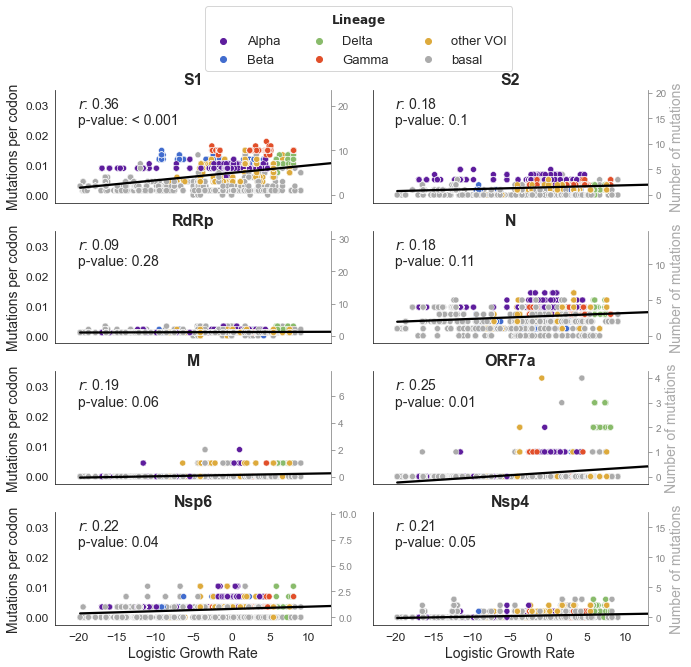

In [111]:
plot_fig1supp_20K(filename='plots/fig1_correlation_20k.png')